In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt
import time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, update, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Latest Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# date 12 months ago from last entry
year_ago= datetime.datetime.strptime(last_date[0], '%Y-%m-%d').date() - dt.timedelta(days=366)


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Making my list of x-variables
last_12_months = session.query(Measurement.date).\
    filter(Measurement.date > str(year_ago)).\
    filter(Measurement.prcp != None).\
    order_by(Measurement.date).all()

lst_yr_dates = [result[0] for result in last_12_months]

# Making my list of y-variables
precip_last_12_months = session.query(Measurement.prcp).\
    filter(Measurement.date > str(year_ago)).\
    filter(Measurement.prcp != None).\
    order_by(Measurement.date).all()

lst_yr_precip = [result[0] for result in precip_last_12_months]

len(lst_yr_dates)

2021

In [16]:
# Load the results into a pandas dataframe. Set the index to the `date column'
df = pd.DataFrame(list(zip(lst_yr_dates,lst_yr_precip)), columns=['Dates', 'Precipitation'])
df.set_index('Dates', inplace=True, )
df.sort_values(by=['Dates'])
df.head(10)

,Precipitation
Dates,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


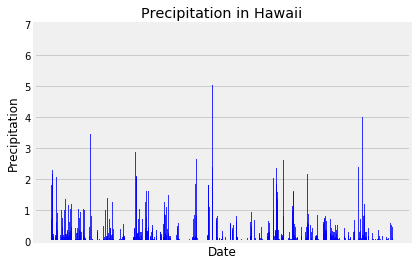

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data

# Creating my canvas
fig,ax = plt.subplots()

# Plotting the results
ax.bar(lst_yr_dates, lst_yr_precip, color='b', alpha=0.8)

# Removing x-ticks because they take up so much space
ax.set_xticks([])

# Setting my labels & Grid
ax.set(xlabel = "Date",ylabel="Precipitation", title="Precipitation in Hawaii");


fig;

![precipitation](Images/precipitation.png)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
amount_stations = session.query(Measurement.station).distinct().count()

print("There are {} stations available in this dataset".format(amount_stations))

There are 9 stations available in this dataset


# Station Analysis

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

from sqlalchemy.orm import Query

query = '''
SELECT
    station,
    COUNT(station) as value_amount
FROM
    Measurement
GROUP BY
    station
ORDER BY
    value_amount DESC;
'''

engine.execute(query).fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Lowest Temperature
low_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').first()

# Highest Temperature
high_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').first()

# Average Temperature
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').first()

print("The lowest temperature recorded at the most active station is {} degrees Farenheit".format(low_temp[0]))
print("The highest temperature recorded at the most active station is {} degrees Farenheit".format(high_temp[0]))
print("The average temperature recorded at the most active station is {} degrees Farenheit".format(int(avg_temp[0])))

The lowest temperature recorded at the most active station is 54.0 degrees Farenheit
The highest temperature recorded at the most active station is 85.0 degrees Farenheit
The average temperature recorded at the most active station is 71 degrees Farenheit


In [26]:
# Choose the station with the highest number of temperature observations.
query2 = '''
SELECT
    station,
    AVG(tobs),
    COUNT(tobs) as value_amount
FROM
    Measurement
WHERE date > '2016-08-22'
GROUP BY
    station
ORDER BY
    value_amount DESC;'''

engine.execute(query2).fetchall()

[('USC00519397', 75.21052631578948, 361),
 ('USC00519281', 73.10795454545455, 352),
 ('USC00516128', 72.09169054441261, 349),
 ('USC00513117', 73.27696793002916, 343),
 ('USC00519523', 76.97032640949556, 337),
 ('USC00514830', 77.16065573770491, 305),
 ('USC00517948', 74.78142076502732, 183)]

In [77]:

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Getting a list of tuples with frequency and temperature 

query3 = '''
SELECT
    station,
    AVG(tobs),
    COUNT(tobs) as value_amount
FROM
    Measurement
WHERE station = 'USC00519397'  AND date > '2016-08-22'
GROUP BY
    tobs
ORDER BY
    tobs DESC;
'''
temp_freq = engine.execute(query3).fetchall()

# Creating my list of x-variables
temp = [x[1] for x in temp_freq]

# Creating my list of y-variables
freq = [x[2] for x in temp_freq]


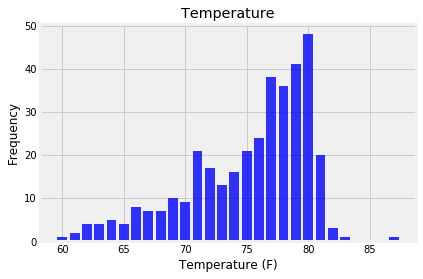

In [83]:
# Creating my canvas
fig2,ax2 = plt.subplots()

# Plotting the results
ax2.bar(temp, freq, color='b', alpha=0.8)


# Setting my labels & Grid
ax2.set(xlabel = "Temperature (F)",ylabel="Frequency", title="Temperature");


fig2;


In [62]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23','2017-08-23'))
stats = calc_temps('2016-08-23','2017-08-23')[0]

[(58.0, 74.59058295964125, 87.0)]


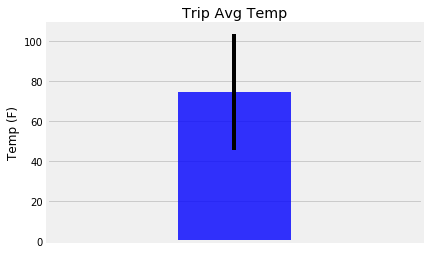

In [64]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Creating my canvas
fig3,ax3 = plt.subplots()

# Plotting the results
ax3.bar('USC00519281',stats[1], yerr = stats[2]- stats[0], color='b', alpha=0.8, width = 0.3, align = 'center')
ax3.set_xlim(-0.5, 0.5)

# Removing x-ticks because we only have 1 x-value
ax3.set_xticks([])

# Setting my labels & Grid
ax3.set(ylabel="Temp (F)", title="Trip Avg Temp");


fig3;